<center>
In God We Trust
</center>

# CE417: Artificial Intelligence

Dr. Mahdiyeh Soleymani Baghshah, Associate Professor

Computer Engineering Department,
Sharif University of Technology,
Tehran, Tehran, Iran


# Classifier (20 Points)

Corresponding TA: Pourya Momtaz

During this assignment, the collective results of all your HITs as a class will be used as datasets to train image classifier. We will be using [fastai](https://docs.fast.ai/), which provides straightforward methods for deep learning. Deep learning utilizes multiple layers of neural networks in order to extract and transform data. Applications of deep learning can be found all around you, including speech recognition, autonomous driving, and board games.

# Install dependencies

You only need to run this once to set the notebook up. Make sure you select Runtime > Change Runtime Type > GPU to get a GPU on Google Colab.

In [2]:
#hide
!pip install fastbook
import fastbook
fastbook.setup_book()
import sklearn
import os

#hide
from fastbook import *

#hide
! curl https://nets213-hw5.s3.amazonaws.com/mega_results_cleaned_validated.csv -o results.csv 
! curl https://nets213-hw5.s3.amazonaws.com/weddings-indian-languages.zip -o  weddings-indian-languages.zip
! curl https://nets213-hw5.s3.amazonaws.com/weddings%2Brandom-european-language.zip -o weddings-european-language.zip
! unzip -o weddings-indian-languages.zip 1>/dev/null
! unzip -o weddings-european-language.zip 1>/dev/null
! rm -rf weddings-european-language 1>/dev/null 2>/dev/null || true
os.rename("weddings+random-european-language","weddings-european-language") # renames the folder for convenience later in the assignment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling ur

# Load all the compiled HITs results

We've provided **mega_results_cleaned_validated.csv**, which is a compilation of all student HIT results. Read it in and for each image, calculate the count of how many Turkers voted yes or no for the image. Note that in order to improve the classifiers' performances, several hundred negative Western images were added to augment the Western dataset of images. These additional Western images were all labeled to not depict weddings.

As you were assigned to randomly shuffle your images, the actual number of votes that each image received isn't uniform. Thus, in the following cells, we will classify an image as True (the image depicts a wedding) if the majority of its votes are yes. For example, if an image received a total of seven votes, if at least four workers voted yes, then we will classify the image as True. If an image received a total of eight votes, if at least five workers voted yes, then we will classify the image as True.

In [3]:
import pandas as pd 
from collections import Counter

df = pd.read_csv("results.csv") # reads a .csv file into a DataFrame
yes_votes = Counter() # holds the number of "yes" votes each image receives
total_votes = Counter() # holds the number of total votes each image receives

for _, row in df.iterrows():
  true_images = row['Answer.selected'].split('|') # splits the string into a list with the specified '|' separator
  for i in range(1, 13):
    url = row["Input.image" + str(i)] 
    if type(url) is not str: continue # this line skips bad entries in CSV

    total_votes[url] += 1 # Add 1 to total_votes when the url received a vote (again, we are try to get the total votes each image receives)

    ##### START CODE HERE: Add 1 to yes_votes when the url has a vote (in other words, when the url is in true_image) #####
    if "image" + str(i) in true_images: yes_votes[url] += 1
    
    ##### END CODE HERE #####

# Train an image classifier to classify weddings

We're going to be classifying whether a photo contains a wedding or not. We'll classify an image as a wedding if a majority of the workers said the image represented a wedding.

We will train a classifier. It will be trained on Western and NonWestern images, and then assessed on both Western and NonWestern images.

In [4]:
from fastai.vision.all import *

def get_path_from_url(url):
  return url.replace('https://s3.amazonaws.com/nets213-hw5/', '')

image_urls = list(total_votes.keys()) # remote URLs to the images
paths = [get_path_from_url(url) for url in image_urls] # local paths to the image files in the Google Colab files

##### START CODE HERE: Write get_label() to return True if the image has a majority of "yes" votes, and False otherwise #####
def get_label(url): 
  if yes_votes[url] > total_votes[url] / 2: return True
  return False 
##### END CODE HERE #####

##### START CODE HERE: Run get_label() on image_urls to create a list called "labels" #####
labels = [get_label(url) for url in image_urls]
##### END CODE HERE #####

# The code below updates the image URLs of the additional negative Western images that we added to improve training
for index in range(0, len(paths)):
  if "random-european-language" in paths[index]:
    sections = paths[index].split('/')
    revised_path = "weddings-european-language/" + ('/').join(sections[1:])
    paths[index] = revised_path

We have the paths and labels from our compiled **mega_results_cleaned.csv**. As stated before, we wish to assess our classifier firstly on Western images and then secondly on NonWestern images. Thus, we need to separate our paths/labels into two separate sets – the set of Western paths/labels and the set of NonWestern paths/labels.

For assessment purposes, we wish to create a test set of Western images and a test set of NonWestern images. These images should not be used to train the classifiers. Thus, we need to split the Western set of images into a training set and a test set, and do the same for the NonWestern set of images.

Note that some image URLs that were provided in the MTurk HITs are not valid URLs. In other words, there are several URLs in **paths** that we should ignore. The following code will also do this filtering.

In [5]:
from sklearn.model_selection import train_test_split
# Western set of images
paths_Western = []
labels_Western = []

# NonWestern set of images
paths_NonWestern = []
labels_NonWestern = []

##### START CODE HERE: Index through the paths and labels and add to either the Western set or NonWestern set – if a path doesn't contain either "indian-languages" or "european-language", ignore it #####
for index_path, path in enumerate(paths):
  if "european-language" in path:
    paths_Western.append(path)
    labels_Western.append(labels[index_path])
  elif "indian-languages" in path:
    paths_NonWestern.append(path)
    labels_NonWestern.append(labels[index_path])
##### END CODE HERE #####

##### START CODE HERE: Split your Western dataset into a training set (80%) and test set (20%), and do the same with your NonWestern dataset – use sklearn.model_selection.train_test_split() with the stratify parameter equal to your labels #####
paths_Western_train, paths_Western_test, labels_Western_train, labels_Western_test = train_test_split(paths_Western, labels_Western, stratify=labels_Western, test_size=0.2)
paths_NonWestern_train, paths_NonWestern_test, labels_NonWestern_train, labels_NonWestern_test = train_test_split(paths_NonWestern, labels_NonWestern, stratify=labels_NonWestern, test_size=0.2)
##### END CODE HERE #####

We will now specify the structure of our dataset and then create and train our model. If the given parameter values are used, the training time should be about a minute and the error rate should be around 10-15%. Try to experiment around with different parameters to further tune the model! Examples of potential improvements are data augmentations, additional epochs, and batch sizes. 

Reference the [documentation](https://docs.fast.ai/vision.data.html#ImageDataLoaders) of ImageDataLoaders to determine the appropriate method to use for the first line.

We will now train our classifier. This classifier will be trained on both our Western training set and NonWestern training set. The Western training set's paths and labels are stored in **paths_Western_train** and **labels_Western_train**. The NonWestern training set's paths and labels are stored in **paths_NonWestern_train** and **labels_NonWestern_train**. We will combine these training sets into **paths_Both_train** and **labels_Both_train**.

In [6]:
##### START CODE HERE: Combine the Western training set and the NonWestern training set #####
paths_Both_train = paths_Western_train + paths_NonWestern_train
labels_Both_train = labels_Western_train + labels_NonWestern_train
##### END CODE HERE #####

##### START CODE HERE: Specify what type of dataset we have and how it's structured with ImageDataLoaders – use a validation percentage of 20%, seed of 42, and item transformation of Resize(224) #####
working_path = './'
dls_Both = ImageDataLoaders.from_lists(working_path, fnames = paths_Both_train, labels = labels_Both_train, valid_pct=0.2, seed=42, item_tfms=Resize(224))
##### END CODE HERE #####

##### START CODE HERE: Create a convolutional neural network called "classifier_Both" with cnn_learner() – use an architecture of resnet34, metric of error_rate, and pretrained of True #####
classifier_Both = cnn_learner(dls_Both, resnet34, metrics=error_rate, pretrained=True)
##### END CODE HERE #####

##### START CODE HERE: Fit the model with fine_tune() – use an epoch of 5
classifier_Both.fine_tune(5)
##### END CODE HERE #####

/usr/local/lib/python3.8/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pt

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.763626,0.418052,0.161476,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.457844,0.320930,0.123414,00:26
1,0.347455,0.318486,0.119954,00:26
2,0.234930,0.360073,0.118800,00:26
3,0.147753,0.319843,0.099193,00:27
4,0.085209,0.311917,0.101499,00:27


Dumping the trained model in storage

In [7]:
import pickle
filename = 'classifier_Both.p'
pickle.dump(classifier_Both, open(filename, "wb"))

Loading the trained model from storage

Try using a sample wedding image found online with this classifier in order to see if it was successfully trained.

In [12]:
### run this if you don't want to train the model again
filename = 'classifier_Both.p'
classifier_Both_pickled = pickle.load(open(filename, "rb"))
classifier_Both = classifier_Both_pickled

In [40]:
# Click on the gray "Upload" button in order to upload your sample wedding image
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

Is this an image of a wedding?: True.
Probability it's a wedding: 0.992839


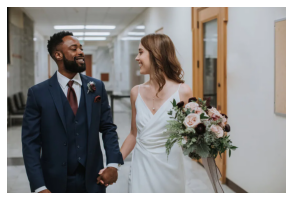

In [41]:
# The model will predict whether or not your uploaded image is that of a wedding
img = PILImage.create(uploader.data[0])
is_wedding,_,probs = classifier_Both.predict(img)
print(f"Is this an image of a wedding?: {is_wedding}.")
print(f"Probability it's a wedding: {probs[1].item():.6f}")
show_image(img)

# Calculate evaluation metrics for our classifier

We will now calculate several evaluation metrics to assess our classifier. Several metrics include precision, recall, and F1-Score. These three metrics can be used to assess how good our classifiers are. An overview can be found [here](https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec). 

A confusion matrix can help visualize the components used in calculating these metrics:

<figure align="center">
<img src="https://miro.medium.com/max/800/1*fxiTNIgOyvAombPJx5KGeA.png" width="350" />
</figure>

*   Precision: The ratio of what our model predicted correctly to what our model predicted
*   Recall: Ratio of what our model predicted correctly to what the actual labels are
*   F1-Score: Harmonic mean of precision and recall

<figure align="center">
<img src="https://miro.medium.com/max/1068/1*EXa-_699fntpUoRjZeqAFQ.jpeg" />
</figure>


In order to have a baseline for comparison, we created a classifier pretrained on ImageNet and obtained the following metrics:

*   NonWestern Precision from ImageNet classifier: 0.658008658008568
*   NonWestern Recall from ImageNet classifier: 0.18225419664268586
*   NonWestern F1-Score from ImageNet classifier: 0.28544600938967135
*   Western Precision from ImageNet classifier: 0.7463414634146341
*   Western Recall from ImageNet classifier: 0.504950495049505
*   Western F1-Score from ImageNet classifier: 0.6023622047244095

Notice that our ImageNet classifier performs worse on the NonWestern images than on Western images, as seen in the difference in F1-Scores. This result could have been anticipated. [Google researchers](https://research.google/pubs/pub46553/) found that ImageNet “appear[s] to exhibit an observable amerocentric and eurocentric representation bias,” as demonstrated by the distribution of geographically identifiable images in the datasets, with 2/3 of the images from the Western world. 

<figure align="center">
<img src="http://crowdsourcing-class.org/images/imagenet_pie_chart.jpg" />
</figure>

We will calculate these metrics for our classifier as well. We will have our classifier predict whether or not these images depict a wedding in order to determine our True Positive, True Negative, False Positive, and False Negative values and ultimately calculate the F1-Scores.

We will use the predictions of your classifier on **paths_Western_test** with **labels_Western_test** to assess the TP, TN, FP, and FN values on Western images. We will use the predictions of your classifier on **paths_NonWestern_test** with **labels_NonWestern_test** to assess the TP, TN, FP, and FN values on NonWestern images.

# Calculate evaluation metrics for your classifier trained on both Western and NonWestern images

Firstly, calculate the precision, recall, and F1-score for your classifier trained on both Western and NonWestern images and assessed with Western images.


In [ ]:
predictions_Both_Western = []

##### START CODE HERE: Create a list called predictions_Both_Western that stores all predictions for the Western images in paths_Western_test #####
predictions_Both_Western = np.array([classifier_Both.predict(PILImage.create(path))[0] for path in paths_Western_train])
actualValues_Both_Western = np.array(labels_Western_train)
##### END CODE HERE #####

In [47]:
import numpy as np
##### START CODE HERE: Calculate the number of True Positives, True Negatives, False Positives, and False Negatives for your classifier_Both on the Western images #####

TP_Both_Western = np.count_nonzero(np.logical_and(predictions_Both_Western == 'True', actualValues_Both_Western == True))
TN_Both_Western = np.count_nonzero(np.logical_and(predictions_Both_Western == 'False', actualValues_Both_Western == False))
FP_Both_Western = np.count_nonzero(np.logical_and(predictions_Both_Western == 'True', actualValues_Both_Western == False))
FN_Both_Western = np.count_nonzero(np.logical_and(predictions_Both_Western == 'False', actualValues_Both_Western == True))
##### END CODE HERE #####

##### START CODE HERE: Calculate precision, recall, and F1-score for your classifier_Both on the Western images #####
precision_Both_Western = TP_Both_Western / (TP_Both_Western + FP_Both_Western)
recall_Both_Western = TP_Both_Western / (TP_Both_Western + FN_Both_Western)
f1_score_Both_Western = 2 * (precision_Both_Western * recall_Both_Western) / (precision_Both_Western + recall_Both_Western)
##### END CODE HERE #####

# Display your confusion matrix, precision, recall, and F1-score for your classifier_Both on the Western images
confusion_matrix_data = [(TP_Both_Western, FP_Both_Western) , (FN_Both_Western, TN_Both_Western)]
confusion_matrix = pd.DataFrame(confusion_matrix_data, columns = ['Actual Wedding' , 'Actual Non-Wedding'], index=['Predicted Wedding', 'Predicted Non-Wedding'])
print("Confusion Matrix:")
display(confusion_matrix)
print("Western Precision from your classifier trained on both Western and NonWestern images: " + str(precision_Both_Western))
print("Western Recall from your classifier trained on both Western and NonWestern images: " + str(recall_Both_Western))
print("Western F1-Score from your classifier trained on both Western and NonWestern images: " + str(f1_score_Both_Western))

Confusion Matrix:


,Actual Wedding,Actual Non-Wedding
Predicted Wedding,265,13
Predicted Non-Wedding,9,815


Western Precision from your classifier trained on both Western and NonWestern images: 0.9532374100719424
Western Recall from your classifier trained on both Western and NonWestern images: 0.9671532846715328
Western F1-Score from your classifier trained on both Western and NonWestern images: 0.9601449275362318


Secondly, calculate the precision, recall, and F1-score for your classifier trained on both Western and NonWestern images and assessed with NonWestern images.


In [ ]:
predictions_Both_NonWestern = []

##### START CODE HERE: Create a list called predictions_Both_NonWestern that stores all predictions for the NonWestern images in paths_NonWestern_test #####
predictions_Both_NonWestern = np.array([classifier_Both.predict(PILImage.create(path))[0] for path in paths_NonWestern_train])
actualValues_Both_NonWestern = np.array(labels_NonWestern_train)
##### END CODE HERE #####

In [49]:
##### START CODE HERE: Calculate the number of True Positives, True Negatives, False Positives, and False Negatives for your classifier_Both on the NonWestern images #####
TP_Both_NonWestern = np.count_nonzero(np.logical_and(predictions_Both_NonWestern == 'True', actualValues_Both_NonWestern == True))
TN_Both_NonWestern = np.count_nonzero(np.logical_and(predictions_Both_NonWestern == 'False', actualValues_Both_NonWestern == False))
FP_Both_NonWestern = np.count_nonzero(np.logical_and(predictions_Both_NonWestern == 'True', actualValues_Both_NonWestern == False))
FN_Both_NonWestern = np.count_nonzero(np.logical_and(predictions_Both_NonWestern == 'False', actualValues_Both_NonWestern == True))
##### END CODE HERE #####

##### START CODE HERE: Calculate precision, recall, and F1-score for your classifier_Both on the NonWestern images #####
precision_Both_NonWestern = TP_Both_NonWestern / (TP_Both_NonWestern + FP_Both_NonWestern)
recall_Both_NonWestern = TP_Both_NonWestern / (TP_Both_NonWestern + FN_Both_NonWestern)
f1_score_Both_NonWestern = 2 * (precision_Both_NonWestern * recall_Both_NonWestern) / (precision_Both_NonWestern + recall_Both_NonWestern)
##### END CODE HERE #####

# Display your confusion matrix, precision, recall, and F1-score for your classifier_Both on the NonWestern images
confusion_matrix_data = [(TP_Both_NonWestern, FP_Both_NonWestern) , (FN_Both_NonWestern, TN_Both_NonWestern)]
confusion_matrix = pd.DataFrame(confusion_matrix_data, columns = ['Actual Wedding' , 'Actual Non-Wedding'], index=['Predicted Wedding', 'Predicted Non-Wedding'])
print("Confusion Matrix:")
display(confusion_matrix)
print("NonWestern Precision from your classifier trained on both Western and NonWestern images: " + str(precision_Both_NonWestern))
print("NonWestern Recall from your classifier trained on both Western and NonWestern images: " + str(recall_Both_NonWestern))
print("NonWestern F1-Score from your classifier trained on both Western and NonWestern images: " + str(f1_score_Both_NonWestern))

Confusion Matrix:


,Actual Wedding,Actual Non-Wedding
Predicted Wedding,1253,56
Predicted Non-Wedding,38,1890


NonWestern Precision from your classifier trained on both Western and NonWestern images: 0.9572192513368984
NonWestern Recall from your classifier trained on both Western and NonWestern images: 0.9705654531371031
NonWestern F1-Score from your classifier trained on both Western and NonWestern images: 0.9638461538461539


# Visual validation on your classifier

> Indented block



In [36]:
import IPython
print("------------------------------------------------------------------")
display(IPython.display.Image(classifier_Western_false_negative_images[0]))
print("Classifier Predicted:", "wedding" if 'True' == str(classifier_Both.predict(classifier_Western_false_negative_images[0])[0]) else "not-wedding")
print("------------------------------------------------------------------")
display(IPython.display.Image(classifier_Western_false_negative_images[1]))
print("Classifier Predicted:", "wedding" if 'True' == str(classifier_Both.predict(classifier_Western_false_negative_images[1])[0]) else "not-wedding")
print("------------------------------------------------------------------")
display(IPython.display.Image(classifier_Western_false_negative_images[2]))
print("Classifier Predicted:", "wedding" if 'True' == str(classifier_Both.predict(classifier_Western_false_negative_images[2])[0]) else "not-wedding")
print("------------------------------------------------------------------")
display(IPython.display.Image(classifier_Western_false_negative_images[3]))
print("Classifier Predicted:", "wedding" if 'True' == str(classifier_Both.predict(classifier_Western_false_negative_images[3])[0]) else "not-wedding")
print("------------------------------------------------------------------")
display(IPython.display.Image(classifier_Western_false_negative_images[4]))
print("------------------------------------------------------------------")
print("Classifier Predicted:", "wedding" if 'True' == str(classifier_Both.predict(classifier_Western_false_negative_images[4])[0]) else "not-wedding")

------------------------------------------------------------------


NameError: ignored